In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import tensorflow as tf
import os

In [4]:
os.chdir('drive/My Drive/Project_Face_Mask_Segmentation')

In [5]:
import numpy as np
data = np.load('images.npy',allow_pickle=True)

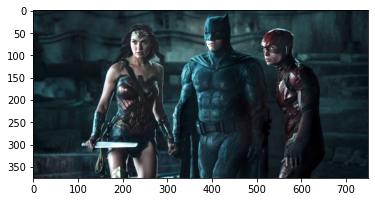

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow((data[15][0]))

In [7]:
IMAGE_WIDTH =224
IMAGE_HEIGHT =224

In [8]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [9]:
print('Shape of training set:' , np.shape(X_train))
print('Shape of masks:' , np.shape(masks))

Shape of training set: (409, 224, 224, 3)
Shape of masks: (409, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


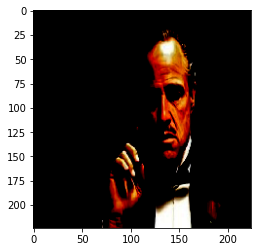

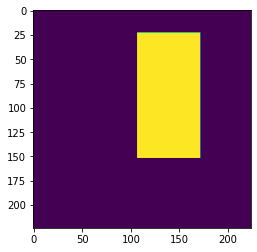

In [10]:
n = 10
plt.imshow(X_train[n])
plt.show()
plt.imshow(masks[n])
plt.show()

Printing Array

In [11]:
print(X_train[n])

[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

MobileNet as model with below parameter values 
input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
include_top: False
alpha: 1.0
weights: "imagenet"
UNET architecture layers

In [12]:
x = X_train

In [13]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape , Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.models import Model


def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3), include_top = False, alpha = 1, weights = "imagenet")
    for layer in model.layers:
        layer.trainable = trainable


    block = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output


    xup1 = Concatenate()([UpSampling2D()(block4), block3])
    conv6 = Conv2D(256, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = (1,1), name = 'conv6')(xup1)
    conv6 = BatchNormalization(name = '6BatchNormalization')(conv6)
    conv6 = Activation('relu', name = '6ActivationLayer')(conv6)

    xup2 = Concatenate()([UpSampling2D()(conv6), block2])
    conv7 = Conv2D(128, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = (1,1), name = 'conv7')(xup2)
    conv7 = BatchNormalization(name = '7BatchNormalization')(conv7)
    conv7 = Activation('relu', name = '7ActivationLayer')(conv7)

    xup3 = Concatenate()([UpSampling2D()(conv7), block1])
    conv8 = Conv2D(64, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = (1,1), name = 'conv8')(xup3)
    conv8 = BatchNormalization(name = '8BatchNormalization')(conv8)
    conv8 = Activation('relu', name = '8ActivationLayer')(conv8)

    xup4 = Concatenate()([UpSampling2D()(conv8), block])
    conv9 = Conv2D(48, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = (1,1), name = 'conv9')(xup4)
    conv9 = BatchNormalization(name = '9BatchNormalization')(conv9)
    conv9 = Activation('relu', name = '9ActivationLayer')(conv9)

    xup5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = Conv2D(32, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = (1,1), name = 'conv10')(xup5)
    conv10 = BatchNormalization(name = '10BatchNormalization')(conv10)
    conv10 = Activation('relu', name = '10ActivationLayer')(conv10)

    conv10 = SpatialDropout2D(0.2)(conv10)
    
    x = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)
    x = Reshape((IMAGE_HEIGHT,IMAGE_WIDTH))(x)
    return Model(inputs = model.input, outputs = x)


In [14]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_____________________________

In [15]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [16]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [17]:
from tensorflow.keras.optimizers import Adam
adam = Adam(lr = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
model.compile(loss = loss, optimizer = adam, metrics = [dice_coefficient])


In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [19]:
from sklearn.model_selection import train_test_split
X_train1, X_valid, y_train, y_valid = train_test_split(x, masks, test_size = 0.15, random_state = 2019, shuffle = False)
X_train1.shape, X_valid.shape, y_train.shape, y_valid.shape

((347, 224, 224, 3), (62, 224, 224, 3), (347, 224, 224), (62, 224, 224))

In [20]:
model.fit(X_train1, y_train, epochs = 20, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_valid, y_valid))


Epoch 1/20
347/347 [==============================] - ETA: 0s - loss: 1.4402 - dice_coefficient: 0.4120
Epoch 00001: loss improved from inf to 1.44022, saving model to model-1.44.h5
347/347 [==============================] - 22s 62ms/step - loss: 1.4402 - dice_coefficient: 0.4120 - val_loss: 1.0730 - val_dice_coefficient: 0.4789 - lr: 1.0000e-04
Epoch 2/20
347/347 [==============================] - ETA: 0s - loss: 1.0360 - dice_coefficient: 0.5182
Epoch 00002: loss improved from 1.44022 to 1.03602, saving model to model-1.04.h5
347/347 [==============================] - 21s 61ms/step - loss: 1.0360 - dice_coefficient: 0.5182 - val_loss: 1.0023 - val_dice_coefficient: 0.4950 - lr: 1.0000e-04
Epoch 3/20
347/347 [==============================] - ETA: 0s - loss: 0.8297 - dice_coefficient: 0.5866
Epoch 00003: loss improved from 1.03602 to 0.82973, saving model to model-0.83.h5
347/347 [==============================] - 21s 61ms/step - loss: 0.8297 - dice_coefficient: 0.5866 - val_loss: 0.9

In [21]:
#Again fitting from last stop
model.fit(X_train1, y_train, epochs = 20, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_valid, y_valid))  

Epoch 1/20
347/347 [==============================] - ETA: 0s - loss: 0.1378 - dice_coefficient: 0.9355
Epoch 00001: loss improved from 0.14099 to 0.13778, saving model to model-0.14.h5
347/347 [==============================] - 21s 60ms/step - loss: 0.1378 - dice_coefficient: 0.9355 - val_loss: 0.8001 - val_dice_coefficient: 0.6474 - lr: 1.0000e-04
Epoch 2/20
347/347 [==============================] - ETA: 0s - loss: 0.1346 - dice_coefficient: 0.9380
Epoch 00002: loss improved from 0.13778 to 0.13463, saving model to model-0.13.h5
347/347 [==============================] - 21s 59ms/step - loss: 0.1346 - dice_coefficient: 0.9380 - val_loss: 0.8280 - val_dice_coefficient: 0.6353 - lr: 1.0000e-04
Epoch 3/20
347/347 [==============================] - ETA: 0s - loss: 0.1304 - dice_coefficient: 0.9411
Epoch 00003: loss improved from 0.13463 to 0.13036, saving model to model-0.13.h5
347/347 [==============================] - 21s 59ms/step - loss: 0.1304 - dice_coefficient: 0.9411 - val_loss:

In [22]:
model.evaluate(X_valid, y_valid, verbose = 1)

2/2 [==============================] - 2s 863ms/step - loss: 1.0184 - dice_coefficient: 0.6233


[1.0184316635131836, 0.6233359575271606]

In [25]:
y_pred = model.predict(X_valid, verbose = 1)

2/2 [==============================] - 0s 110ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


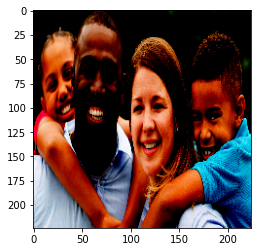

In [55]:
n = 10
plt.imshow(X_valid[n])
plt.show()

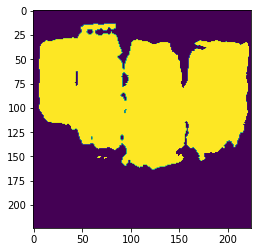

In [56]:
plt.imshow(pred_mask, alpha = 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


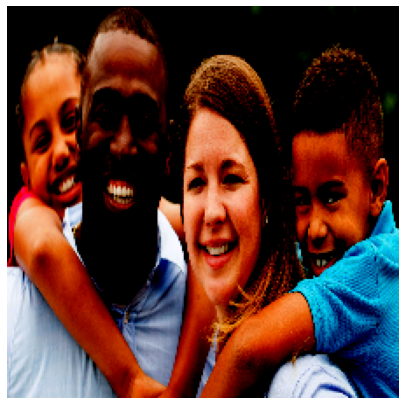

In [42]:

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(X_valid[n])
plt.savefig('image.jpg', bbox_inches = 'tight', pad_inches = 0)

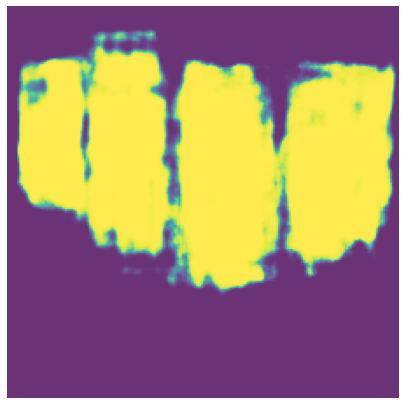

In [43]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(y_pred[n], alpha = 0.8)
plt.savefig('mask.jpg', bbox_inches = 'tight', pad_inches = 0)

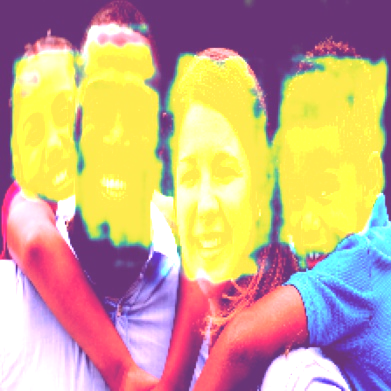

In [44]:
from google.colab.patches import cv2_imshow
img = cv2.imread('image.jpg', 1)
mask = cv2.imread('mask.jpg', 1)
img = cv2.add(img, mask)
cv2_imshow(img)

**Conclusion**: Successfully applied unet layer with backbone as mobilenet model for image segmentation. Chanllenges in understanding the mobilenet model was tricky since upsampling according to the layer size was important. 

Dice coefficient on training sample was .967 and on validation set was .623

After successfull transfer learning and unet model training of only deconvolutional part, i've imposed a mask on orig image.